$\newcommand{\xv}{\mathbf{x}}
\newcommand{\Xv}{\mathbf{X}}
\newcommand{\yv}{\mathbf{y}}
\newcommand{\zv}{\mathbf{z}}
\newcommand{\av}{\mathbf{a}}
\newcommand{\Wv}{\mathbf{W}}
\newcommand{\wv}{\mathbf{w}}
\newcommand{\tv}{\mathbf{t}}
\newcommand{\Tv}{\mathbf{T}}
\newcommand{\muv}{\boldsymbol{\mu}}
\newcommand{\sigmav}{\boldsymbol{\sigma}}
\newcommand{\phiv}{\boldsymbol{\phi}}
\newcommand{\Phiv}{\boldsymbol{\Phi}}
\newcommand{\Sigmav}{\boldsymbol{\Sigma}}
\newcommand{\Lambdav}{\boldsymbol{\Lambda}}
\newcommand{\half}{\frac{1}{2}}
\newcommand{\argmax}[1]{\underset{#1}{\operatorname{argmax}}}
\newcommand{\argmin}[1]{\underset{#1}{\operatorname{argmin}}}$

# Assignment 1: Linear Regression

*Sean Russell*

## Overview

Within these pages I will dazzle you with mystical, magical, computational black magic. First, I created some algorithms to analyze a dataset using linear regression, then further down I put the model to the test on data from a power plant, attempting to predict power output based on atmoshperic conditions

## Method

For this linear regression analysis, there are three functions:

  * ```train(training input,target values)```
  * ```use(model,prediction input)```
  * ```rmse(predicted values,target values)```

The train function is used to create the regression model. Both the training input and the target values are matrices, and the train function returns a vector of weights. The formula
$$
\begin{align*}
\wv &= (\Xv^T \Xv)^{-1} \Xv^T \Tv
\end{align*}
$$

is used to find the best fit for a data set, where $\wv$ is the weight vector, $\Xv$ is the matrix of training values, and $\Tv$ is the corresponding matrix of target values.

The use function takes the vector of weights returned by the train fucntion and a matrix of values for which the resulting prediction is desired, and returns a vector of values using the formula
$$
\begin{align*}
\yv &= \Xv \wv
\end{align*}
$$

where $\yv$ is the predicted values based on the model $\wv$ and the input data $\Xv$.

The rmse function takes the values predicted by the use function, compares them against the actual values and returns the error in the model as a scalar.

### Python Implementation

The methods defined here are the same as those formulas above, excepting a few minor differences. Both the train and the use methods standardize their inputs into a normal distribution, so that interpretation of the model is easier. Because of this, the train method now returns a dictionary that includes the weights produced by the model as well as  the means and standard deviations of each dimension of the training data. The use method incorporates these factors when making its predictions. The rmse method is the same as above.

In [2]:
import numpy as np

def train(X,T):
    means = X.mean(axis=0)
    stds = X.std(axis=0)
    Xs = (X - means) / stds
    Xs1 = np.insert(Xs, 0, 1, axis=1)
    w = np.linalg.lstsq(Xs1, T)[0]
    return {'means':means,'stds':stds,'w':w}

def use(model,X):
    Xs = (X - model['means']) / model['stds']
    Xs1 = np.insert(Xs, 0, 1, axis=1)
    return np.dot(Xs1,model['w'])

def rmse(predict,T):
    return np.sqrt(np.mean((predict-T)**2,axis=0))

## Data

The data I am analyzing here comes from the UCI machine learning repository. It is data on a [power plant](http://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant) taken over 6 years, tracking the electrical energy output of the plant based on atmospheric variables, such as humidity and temperature. The data is provided in an excel spreadsheet, so I am using the xlrd python package to import the data

In [2]:
import xlrd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

path = './CCPP/Folds5x2_pp.xlsx'
workbook = xlrd.open_workbook(path)

and read it from the sheet into a 2d list

In [3]:
worksheet = workbook.sheet_by_index(0)
labels = ['Ambient Temperature (C)','Exhaust Steam (cm Hg)','Ambient Pressure (millibar)',
          'Relative Humidity (%)','Electrical Output (MW)']
data = np.zeros((worksheet.nrows-1,5))

for i in range(1,worksheet.nrows):
    for j in range(0,5):
        data[i-1][j] = float(worksheet.cell_value(i,j))

Now that the data is imported, I tried plotting each variable against energy output to see what relationships might exist

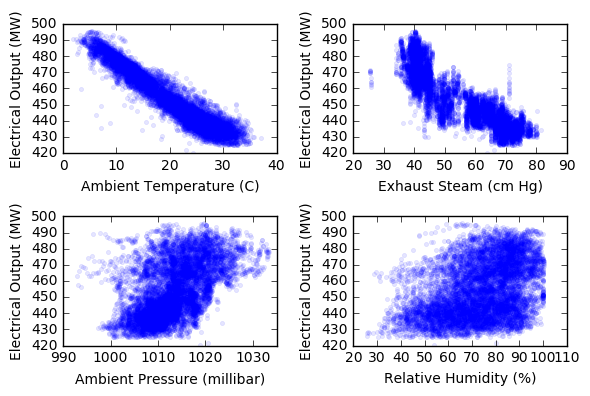

In [4]:
for i in range(0,4):
    ax = plt.subplot(2,2, i+1)
    plt.plot(data[:,i],data[:,4],'.',alpha=.1)
    plt.xlabel(labels[i])
    plt.ylabel(labels[4])
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    
plt.tight_layout()

There seems to be fairly strong negative correlations between both ambient temperature and the pressure of the exhaust and the resulting energy output. Humidity and ambient pressure seem to be somewhat positively correlated with energy output, but the data is much more scattered and not as clear cut.

## Results

Now I use the regression algorithms

In [5]:
inputData = data[:,:4]
target = data[:,4,None]

model = train(inputData,target)
predict = use(model,inputData)
error = rmse(predict,target)

and plot the values predicted by the regression algorithms against the actual values of the dataset.

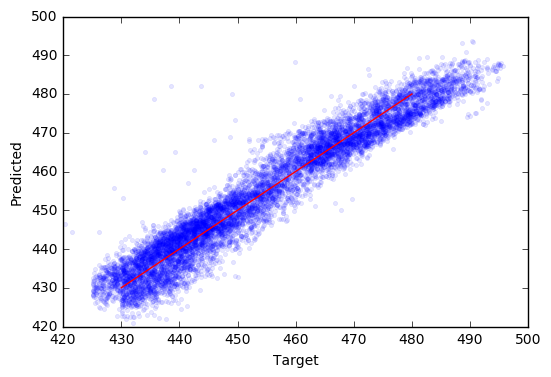

In [6]:
plt.plot(target,predict,'.',alpha=.1)
plt.plot( [430,480],[430,480],'-r')
plt.xlabel('Target')
plt.ylabel('Predicted');

The model seems like a very good fit. The variables seem to have a linear relationship, using some other curve would probably not produce better results. Another way to evaluate the model is to check the error, so here is the error in plain numbers and as a percentage:

In [7]:
print('Error: ' + str(error[0]))
print('Percent error: ' + '%.2f' % (error[0] / (max(predict)-min(predict))[0]*100) + '%')

Error: 4.55712601675
Percent error: 6.27%


6.3% error is pretty good if I do say so myself. This model is a pretty close fit, but I also though I would try putting the model in a human readable format to see if there was anything else to learn

In [8]:
print('\t\t\t\tw\t\tmeans\t\tstds\n')
for i in range(0,4):
    print(labels[i] + ':  \t' + '%.2f' % model['w'][i+1][0] +
          '\t\t' + '%.2f' % model['means'][i] +
          '\t\t' + '%.2f' % model['stds'][i])

				w		means		stds

Ambient Temperature (C):  	-14.74		19.65		7.45
Exhaust Steam (cm Hg):  	-2.97		54.31		12.71
Ambient Pressure (millibar):  	0.37		1013.26		5.94
Relative Humidity (%):  	-2.31		73.31		14.60


From this it is easy to see that the ambient temperature is by far the most important factor in energy output. By contrast, ambient pressure has almost no effect whatsoever on the energy output within this model. So, removing it from the model...

Error: 4.56738081232
Percent error: 6.29%
				w		means		stds

Ambient Temperature (C):  	-15.04		19.65		7.45
Exhaust Steam (cm Hg):  	-2.90		54.31		12.71
Relative Humidity (%):  	-2.41		73.31		14.60


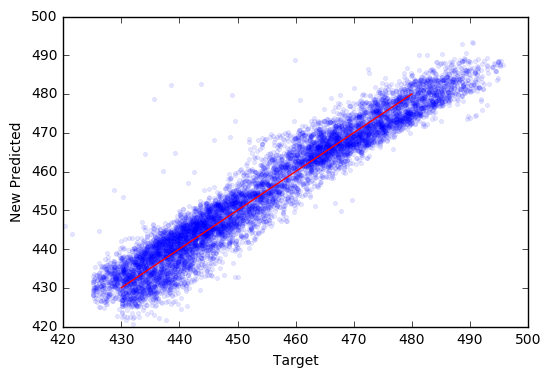

In [9]:
newInputData = np.delete(data[:,:4],2,1)

newModel = train(newInputData,target)
newPredict = use(newModel,newInputData)
newError = rmse(newPredict,target)

plt.plot(target,newPredict,'.',alpha=.1)
plt.plot( [430,480],[430,480],'-r')
plt.xlabel('Target')
plt.ylabel('New Predicted')

print('Error: ' + str(newError[0]))
print('Percent error: ' + '%.2f' % (newError[0] / (max(newPredict)-min(newPredict))[0]*100) + '%')

print('\t\t\t\tw\t\tmeans\t\tstds\n')
print(labels[0] + ':  \t' + '%.2f' % newModel['w'][1][0] + '\t\t' + '%.2f' % newModel['means'][0] +
      '\t\t' + '%.2f' % newModel['stds'][0])
print(labels[1] + ':  \t' + '%.2f' % newModel['w'][2][0] + '\t\t' + '%.2f' % newModel['means'][1] +
      '\t\t' + '%.2f' % newModel['stds'][1])
print(labels[3] + ':  \t' + '%.2f' % newModel['w'][3][0] + '\t\t' + '%.2f' % newModel['means'][2] +
      '\t\t' + '%.2f' % newModel['stds'][2])

does about what was expected. There is an extremely tiny loss of accuracy (0.02%) and some tiny fluctuations in the weights within the model, but overall the differences are minimal. The remaining three varialbes have fairly significant weights associated with them, so its probably best to leave them in place.

## Grading

In [ ]:
%run -i "A1grader.py"